## NLP Final Project
Jesús Echevarría y Patricia Medina

El conjunto de datos que hemos utilizado para realizar esta práctica recoge 42.000 reviews publicadas en Trip Advisor por los visitantes de 3 parques temáticos de DisneyLand, el de París, el de California y el de Hong Kong.

### Cargamos las librerías necesarias

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime
sns.set()
%matplotlib inline 
import re 
import string 
import math
import os
import plotly.express as px
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
from textwrap import wrap
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim.models.word2vec as w2v
import multiprocessing
import pprint
import sklearn.manifold
from __future__ import absolute_import, division, print_function
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

### Leemos los datos

In [2]:
os.getcwd()

'C:\\Users\\HP\\Documents\\GitHub\\NLP-Final-project'

In [3]:
df = pd.read_csv('DisneylandReviews.csv', encoding='latin-1', na_values=['missing'])
df.head()

Review_ID  Rating Year_Month     Reviewer_Location  \
0  670772142       4     2019-4             Australia   
1  670682799       4     2019-5           Philippines   
2  670623270       4     2019-4  United Arab Emirates   
3  670607911       4     2019-4             Australia   
4  670607296       4     2019-4        United Kingdom   

                                         Review_Text               Branch  
0  If you've ever been to Disneyland anywhere you...  Disneyland_HongKong  
1  Its been a while since d last time we visit HK...  Disneyland_HongKong  
2  Thanks God it wasn   t too hot or too humid wh...  Disneyland_HongKong  
3  HK Disneyland is a great compact park. Unfortu...  Disneyland_HongKong  
4  the location is not in the city, took around 1...  Disneyland_HongKong

In [4]:
df.shape

(42656, 6)

Tenemos un conjunto de datos con 42.656 filas y 6 columnas, en las columnas tenemos información del ID del usuario que ha puesto la reseña en Trip Advisor, su calificación del 1 al 5, el año y mes de la visita a DisneyLand, el país de origen del visitante, la reseña y la ciudad en la que está el parque temático.

### Análisis exploratorio

En este paso hemos limpiado el conjunto de datos eliminando los duplicados y los missings

In [5]:
df.isnull().sum()

Review_ID               0
Rating                  0
Year_Month           2613
Reviewer_Location       0
Review_Text             0
Branch                  0
dtype: int64

In [6]:
df=df.dropna().reset_index()

In [7]:
df.duplicated(subset='Review_Text', keep='first').sum()

21

In [8]:
df.drop_duplicates(subset='Review_Text', inplace=True, keep='first')

### Distribución de los datos

Hemos representado de forma gráfica la información de las distintas columnas del dataset con la intención de entender mejor los datos de partida. 

#### Visitantes por filial
Observamos que la filial con más visitantes a lo largo de todo el periodo de tiempo es California, seguida de París y por último HongKong.

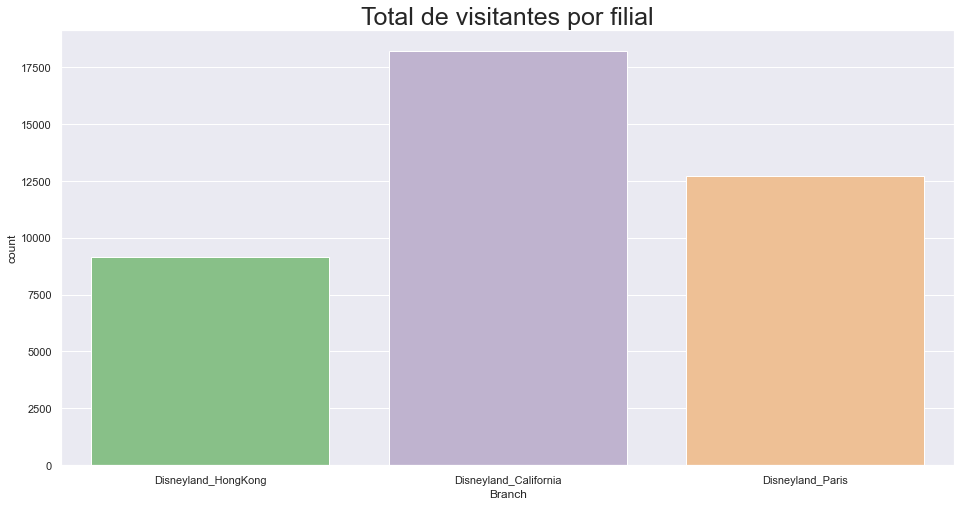

In [80]:
ax = sns.countplot(data=df, x="Branch", palette="Accent").set_title('Total de visitantes por filial', fontsize=25)

#### Rating medio por filial
Observamos que la filial con mejor media de ratings es California, esto también puede deberse a que sus visitantes, como hemos visto en el gráfico anterior son casi el doble de los visitantes de París. En segundo lugar se encuentra Hong Kong y por último París.

Text(0.5, 1.0, 'Calificación media de las reseñas por filial')

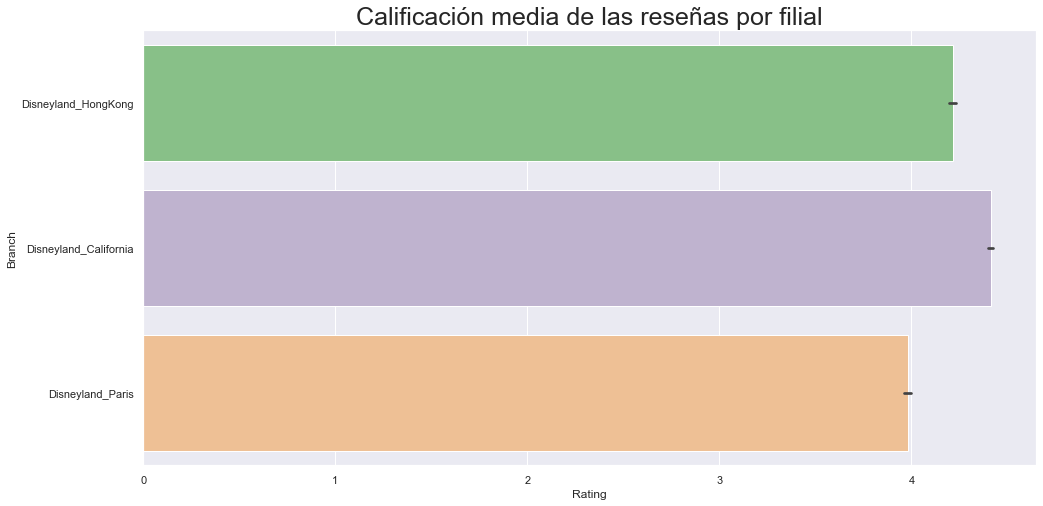

In [81]:
sns.barplot(y=df['Branch'],x=df['Rating'], palette="Accent").set_title('Calificación media de las reseñas por filial', fontsize=25)

#### 25 Nacionalidades con los ratings más altos
Cabe destacar que el top 10 de la media de los ratings cuando se agrupa por nacionalidad es de 5 estrellas para los primeros 24 países

Text(0.5, 1.0, 'Top 25 best ratings')

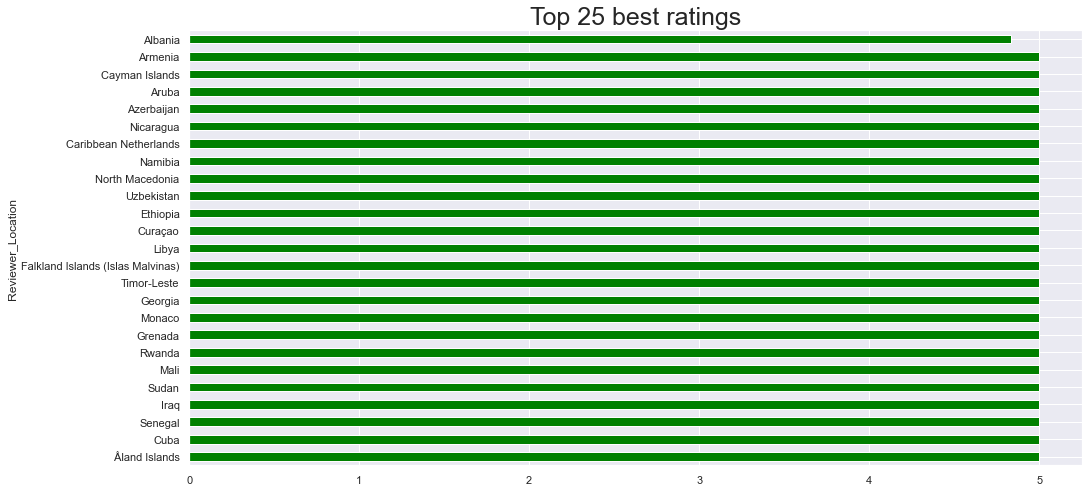

In [89]:
x = df.groupby('Reviewer_Location')['Rating'].mean().sort_values(ascending=False).head(25)
x.plot(kind='barh', color='Green').set_title('Top 25 best ratings', fontsize=25)

#### 10 nacionalidades con los peores ratings
La media de los peores ratings, agrupado por nacionalidad es de 2 estrellas

Text(0.5, 1.0, 'Top 10 worst ratings')

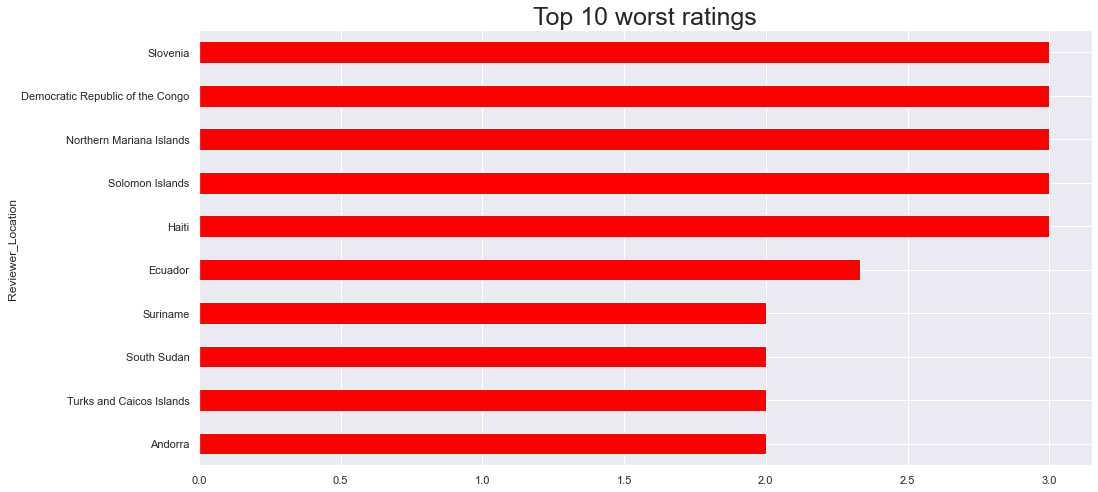

In [90]:
x = df.groupby('Reviewer_Location')['Rating'].mean().sort_values(ascending=True).head(10)
x.plot(kind='barh', color='Red').set_title('Top 10 worst ratings', fontsize=25)

#### Separamos la variable mes-año, en una que sea mes y otra año

In [13]:
new = df["Year_Month"].str.split("-", n = 1, expand = True) 
df["year"]= new[0] 
df["month"]= new[1] 
df.drop(columns =["Year_Month"], inplace = True)

In [14]:
df["year"]=df["year"].astype('int64')
df['month']=df['month'].astype('int64')

#### Total de visitantes en función del año
El año con mayor número de visitantes ha sido 2015 para todas las filiales, observamos que para todos los años, California es la filial más visitada, seguida de París y por último Hong Kong, al igual que veíamos en los datos agregados.

<AxesSubplot:xlabel='year', ylabel='count'>

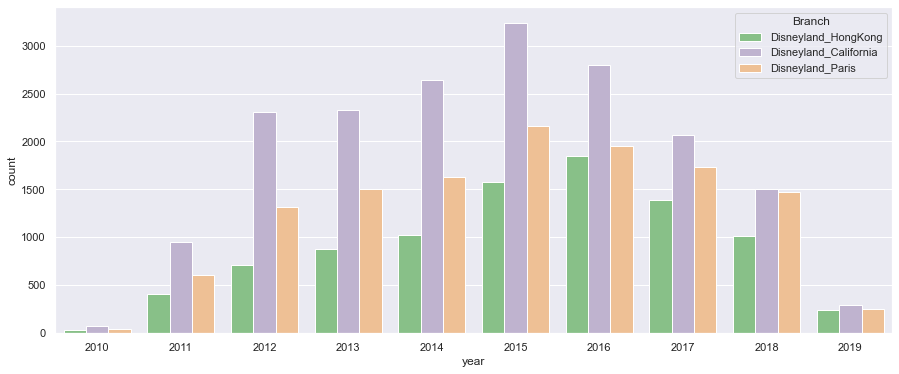

In [15]:
plt.figure(figsize=(15,6))
sns.countplot(data=df,x='year',hue='Branch',palette='Accent')

#### Representamos el total de visitantes en función del mes

<AxesSubplot:xlabel='month', ylabel='count'>

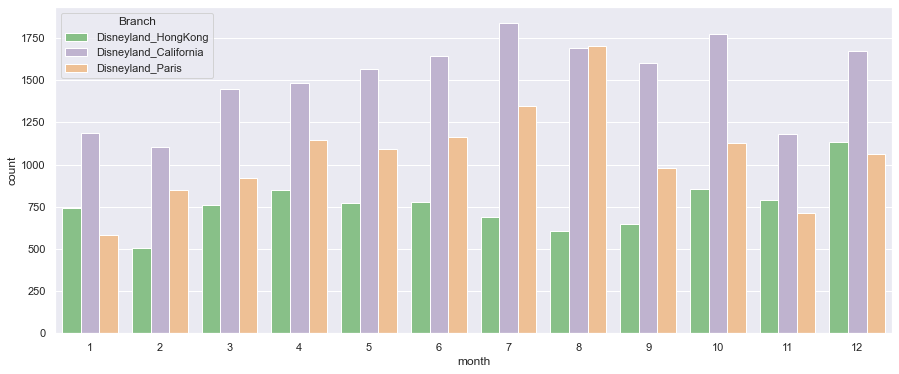

In [16]:
plt.figure(figsize=(15,6))
sns.countplot(data=df,x='month',hue='Branch',palette='Accent')

#### Representamos el total de reseñas por país

In [17]:
fig_df=df.groupby('Reviewer_Location',as_index=False).agg({'Branch':'count'}).sort_values('Branch',ascending=False)
fig = px.choropleth(fig_df, 
                    locations='Reviewer_Location', locationmode='country names',
                    color='Branch',
                    color_continuous_scale="magenta",
                    hover_data=['Branch'],
                    title='Reseñas por país')
fig.show();

#### Preprocesamiento de las reviews

In [18]:
# Separamos en dos frases cuando haya una coma
df['Review_Text'] = df['Review_Text'].apply(lambda x: x.split(',')[0])

In [19]:
# Diccionario de contracciones inglesas
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Buscamos las contracciones mediante una expresión regular
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
# Aplicamos la función para descontraerlas
def expand_contractions(text, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Expandimos las contracciones de las reviews
df['text_withNo_Contractions'] = df['Review_Text'].apply(lambda x: expand_contractions(x))
df[['Review_Text', 'text_withNo_Contractions']].head()

Review_Text  \
0  If you've ever been to Disneyland anywhere you...   
1  Its been a while since d last time we visit HK...   
2  Thanks God it wasn   t too hot or too humid wh...   
3  HK Disneyland is a great compact park. Unfortu...   
4                    the location is not in the city   

                            text_withNo_Contractions  
0  If you have ever been to Disneyland anywhere y...  
1  Its been a while since d last time we visit HK...  
2  Thanks God it wasn   t too hot or too humid wh...  
3  HK Disneyland is a great compact park. Unfortu...  
4                    the location is not in the city

In [20]:
# Convertimos el texto a minúsculas
df['lower_case'] = df['text_withNo_Contractions'].apply(lambda x: x.lower())
df[['Review_Text', 'lower_case']].head()

Review_Text  \
0  If you've ever been to Disneyland anywhere you...   
1  Its been a while since d last time we visit HK...   
2  Thanks God it wasn   t too hot or too humid wh...   
3  HK Disneyland is a great compact park. Unfortu...   
4                    the location is not in the city   

                                          lower_case  
0  if you have ever been to disneyland anywhere y...  
1  its been a while since d last time we visit hk...  
2  thanks god it wasn   t too hot or too humid wh...  
3  hk disneyland is a great compact park. unfortu...  
4                    the location is not in the city

In [21]:
# Eliminamos números
df['text_with_no_digits'] = df['lower_case'].apply(lambda x: re.sub('\w*\d\w*','', x))
df[['Review_Text', 'text_with_no_digits']].head()

Review_Text  \
0  If you've ever been to Disneyland anywhere you...   
1  Its been a while since d last time we visit HK...   
2  Thanks God it wasn   t too hot or too humid wh...   
3  HK Disneyland is a great compact park. Unfortu...   
4                    the location is not in the city   

                                 text_with_no_digits  
0  if you have ever been to disneyland anywhere y...  
1  its been a while since d last time we visit hk...  
2  thanks god it wasn   t too hot or too humid wh...  
3  hk disneyland is a great compact park. unfortu...  
4                    the location is not in the city

In [22]:
# Eliminamos signos de puntuación
df['Text_withNo_punct'] = df['text_with_no_digits'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
df[['Review_Text', 'Text_withNo_punct']].head()

Review_Text  \
0  If you've ever been to Disneyland anywhere you...   
1  Its been a while since d last time we visit HK...   
2  Thanks God it wasn   t too hot or too humid wh...   
3  HK Disneyland is a great compact park. Unfortu...   
4                    the location is not in the city   

                                   Text_withNo_punct  
0  if you have ever been to disneyland anywhere y...  
1  its been a while since d last time we visit hk...  
2  thanks god it wasn   t too hot or too humid wh...  
3  hk disneyland is a great compact park unfortun...  
4                    the location is not in the city

In [23]:
# Eliminamos espacios que sobran
df['Text_withNo_punct'] = df['Text_withNo_punct'].apply(lambda x: re.sub(' +', ' ',x))
df.head()

index  Review_ID  Rating     Reviewer_Location  \
0      0  670772142       4             Australia   
1      1  670682799       4           Philippines   
2      2  670623270       4  United Arab Emirates   
3      3  670607911       4             Australia   
4      4  670607296       4        United Kingdom   

                                         Review_Text               Branch  \
0  If you've ever been to Disneyland anywhere you...  Disneyland_HongKong   
1  Its been a while since d last time we visit HK...  Disneyland_HongKong   
2  Thanks God it wasn   t too hot or too humid wh...  Disneyland_HongKong   
3  HK Disneyland is a great compact park. Unfortu...  Disneyland_HongKong   
4                    the location is not in the city  Disneyland_HongKong   

   year  month                           text_withNo_Contractions  \
0  2019      4  If you have ever been to Disneyland anywhere y...   
1  2019      5  Its been a while since d last time we visit HK...   
2  2019      4  Thanks God it wasn   t too hot or too humid wh...   
3  2019      4  HK Disneyland is a great compact park. Unfortu...   
4  2019      4                    the location is not in the city   

                                          lower_case  \
0  if you have ever been to disneyland anywhere y...   
1  its been a while since d last time we visit hk...   
2  thanks god it wasn   t too hot or too humid wh...   
3  hk disneyland is a great compact park. unfortu...   
4                    the location is not in the city   

                                 text_with_no_digits  \
0  if you have ever been to disneyland anywhere y...   
1  its been a while since d last time we visit hk...   
2  thanks god it wasn   t too hot or too humid wh...   
3  hk disneyland is a great compact park. unfortu...   
4                    the location is not in the city   

                                   Text_withNo_punct  
0  if you have ever been to disneyland anywhere y...  
1  its been a while since d last time we visit hk...  
2  thanks god it wasn t too hot or too humid when...  
3  hk disneyland is a great compact park unfortun...  
4                    the location is not in the city

In [24]:
# !python -m spacy download en_core_web_sm

In [25]:
# Eliminamos las stopwords
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])
# Texto una vez aplicada la lematización
df['lemmatized'] = df['Text_withNo_punct'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

In [26]:
df[['Review_Text','lemmatized']].head()

Review_Text  \
0  If you've ever been to Disneyland anywhere you...   
1  Its been a while since d last time we visit HK...   
2  Thanks God it wasn   t too hot or too humid wh...   
3  HK Disneyland is a great compact park. Unfortu...   
4                    the location is not in the city   

                                          lemmatized  
0  disneyland find disneyland hong kong similar l...  
1                         d time visit hk disneyland  
2  thanks god wasn t hot humid visit park big iss...  
3  hk disneyland great compact park unfortunately...  
4                                      location city

In [27]:
# Agrupamos por la ciudad en la que está DisneyLand
df_grouped = df[['Branch', 'lemmatized']].groupby(by='Branch').agg(lambda x: ' '.join(x))
df_grouped.head()

lemmatized
Branch                                                                  
Disneyland_California  place forever special feeling enter park great...
Disneyland_HongKong    disneyland find disneyland hong kong similar l...
Disneyland_Paris       ve disneyland hongkong tokyo go disneyland par...

#### Nubes de palabras más frecuentes

C:\Users\HP\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



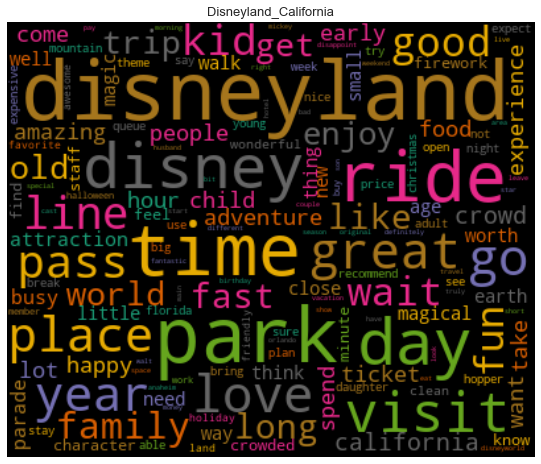

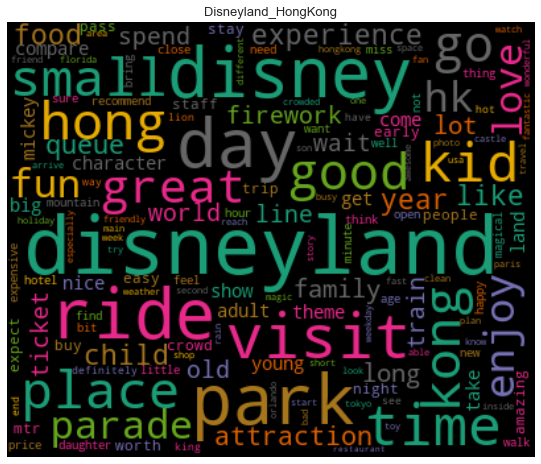

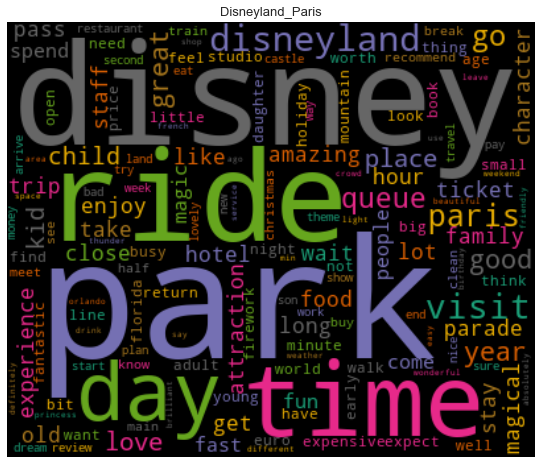

In [28]:
cv = CountVectorizer(analyzer='word')
data = cv.fit_transform(df_grouped['lemmatized'])
df_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
df_dtm.index = df_grouped.index


# Generamos nubes de puntos
def generate_wordcloud(data,title):
    wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
    plt.figure(figsize=(10,8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title('\n'.join(wrap(title,60)),fontsize=13)
    plt.show()
    
# Trasponemos la matriz de términos del documento
df_dtm=df_dtm.transpose()

# Dibujamos una nube de puntos por cada ciudad
for index,product in enumerate(df_dtm.columns):
    generate_wordcloud(df_dtm[product].sort_values(ascending=False),product)

#### Etiquetamos los datos utilizando el rating

In [29]:
# Ahora veo si lo hago o no

In [30]:
rating = df["Rating"]
def label_func(rating):
    if rating >=4:
        return "Positive"
    elif rating == 3:
            return "Neutral"
    else:
        return "Negative"
        
df["Sentiment"] = df["Rating"].apply(lambda x: label_func(x))   

### Sentiment Analysis

Realizamos el análisis de sentimientos, para determinar si la reseña es positiva, negativa o neutral, usando la librería textblob, esta calcula tanto la polaridad como la subjetividad del texto.

La polaridad es un número real que está en el rango [-1,1], siendo 1 un enunciado positivo y -1 un enunciado negativo.  
La subjetividad hace referencia a opiniones personales, emociones o juicios, mientras que la objetividad se basa en hechos fácticos. La subjetividad se calcula en el rango de [0,1]

#### Cálculo de la polaridad y subjetividad

In [31]:
polarity = []

for sentence in df["Review_Text"]:
    polarity.append(TextBlob(sentence).polarity)

In [32]:
subjectivity = []

for sentence in df["Review_Text"]:
    subjectivity.append(TextBlob(sentence).subjectivity)

In [33]:
df["tb_polarity"], df["tb_subjectivity"] = polarity, subjectivity

#### Cálculo del score mediante vader

VADER (Valence Aware Dictionary and sEntiment Reasoner) se basa en el reglas léxicas y en los sentimientos expresados en redes sociales. VADER usa una combinación de un léxico de sentimientos, una lista de características léxicas que generalmente se etiquetan según su orientación semántica como positivas o negativas. No solo informa sobre la puntuación de positividad y negatividad, sino que también nos informa sobre qué tan positivo o negativo es un sentimiento.

In [34]:
analyzer = SentimentIntensityAnalyzer()

vs = []

for sentence in df["Review_Text"]:
    vs.append(analyzer.polarity_scores(sentence))

In [35]:
df["vs_score"] = vs

In [36]:
df['compound'] = df['vs_score'].apply(lambda score_dict: score_dict['compound'])
df['vs_sentiment_type']=''
df.loc[df.compound>0,'vs_sentiment_type']='POSITIVE'
df.loc[df.compound==0,'vs_sentiment_type']='NEUTRAL'
df.loc[df.compound<0,'vs_sentiment_type']='NEGATIVE'

In [37]:
df.head()

index  Review_ID  Rating     Reviewer_Location  \
0      0  670772142       4             Australia   
1      1  670682799       4           Philippines   
2      2  670623270       4  United Arab Emirates   
3      3  670607911       4             Australia   
4      4  670607296       4        United Kingdom   

                                         Review_Text               Branch  \
0  If you've ever been to Disneyland anywhere you...  Disneyland_HongKong   
1  Its been a while since d last time we visit HK...  Disneyland_HongKong   
2  Thanks God it wasn   t too hot or too humid wh...  Disneyland_HongKong   
3  HK Disneyland is a great compact park. Unfortu...  Disneyland_HongKong   
4                    the location is not in the city  Disneyland_HongKong   

   year  month                           text_withNo_Contractions  \
0  2019      4  If you have ever been to Disneyland anywhere y...   
1  2019      5  Its been a while since d last time we visit HK...   
2  2019      4  Thanks God it wasn   t too hot or too humid wh...   
3  2019      4  HK Disneyland is a great compact park. Unfortu...   
4  2019      4                    the location is not in the city   

                                          lower_case  \
0  if you have ever been to disneyland anywhere y...   
1  its been a while since d last time we visit hk...   
2  thanks god it wasn   t too hot or too humid wh...   
3  hk disneyland is a great compact park. unfortu...   
4                    the location is not in the city   

                                 text_with_no_digits  \
0  if you have ever been to disneyland anywhere y...   
1  its been a while since d last time we visit hk...   
2  thanks god it wasn   t too hot or too humid wh...   
3  hk disneyland is a great compact park. unfortu...   
4                    the location is not in the city   

                                   Text_withNo_punct  \
0  if you have ever been to disneyland anywhere y...   
1  its been a while since d last time we visit hk...   
2  thanks god it wasn t too hot or too humid when...   
3  hk disneyland is a great compact park unfortun...   
4                    the location is not in the city   

                                          lemmatized Sentiment  tb_polarity  \
0  disneyland find disneyland hong kong similar l...  Positive     0.243981   
1                         d time visit hk disneyland  Positive     0.000000   
2  thanks god wasn t hot humid visit park big iss...  Positive    -0.042857   
3  hk disneyland great compact park unfortunately...  Positive     0.140000   
4                                      location city  Positive     0.000000   

   tb_subjectivity                                           vs_score  \
0         0.561481  {'neg': 0.0, 'neu': 0.891, 'pos': 0.109, 'comp...   
1         0.066667  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   
2         0.350000  {'neg': 0.048, 'neu': 0.853, 'pos': 0.099, 'co...   
3         0.570000  {'neg': 0.058, 'neu': 0.803, 'pos': 0.138, 'co...   
4         0.000000  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   

   compound vs_sentiment_type  
0    0.7069          POSITIVE  
1    0.0000           NEUTRAL  
2    0.3818          POSITIVE  
3    0.5070          POSITIVE  
4    0.0000           NEUTRAL

<AxesSubplot:xlabel='vs_sentiment_type', ylabel='count'>

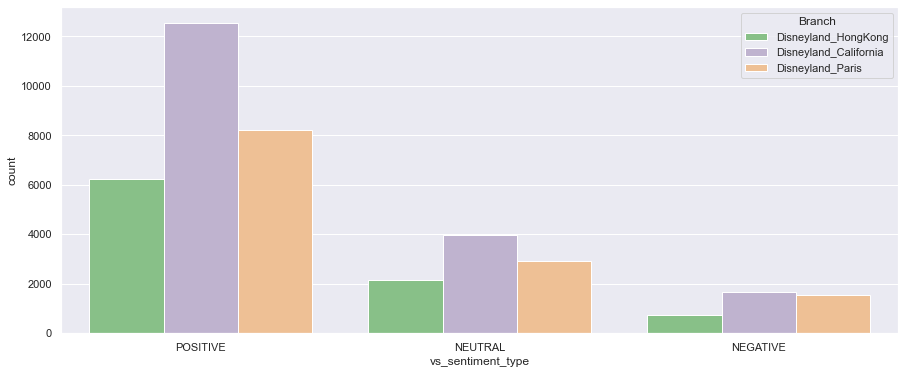

In [38]:
plt.figure(figsize=(15,6))
sns.countplot(data=df,x='vs_sentiment_type',hue='Branch',palette='Accent')

Nos fijamos en las nubes de puntos y elegimos un conjunto de palabras positivas que aparezcan con frecuencia en las reseñas

In [39]:
specific_words = ['happiest place', 'happiest place on earth', 'magic', 'magical']

query = '|'.join(specific_words)

df['query_match'] = df['Review_Text'].str.lower().str.contains(query)

In [40]:
matches = df[(df['query_match'] == True)]
matches.shape

(4088, 20)

In [41]:
df_like = df[(df['query_match'] == True) & (df['vs_sentiment_type'] == 'POSITIVE')]

<AxesSubplot:xlabel='tb_polarity', ylabel='Density'>

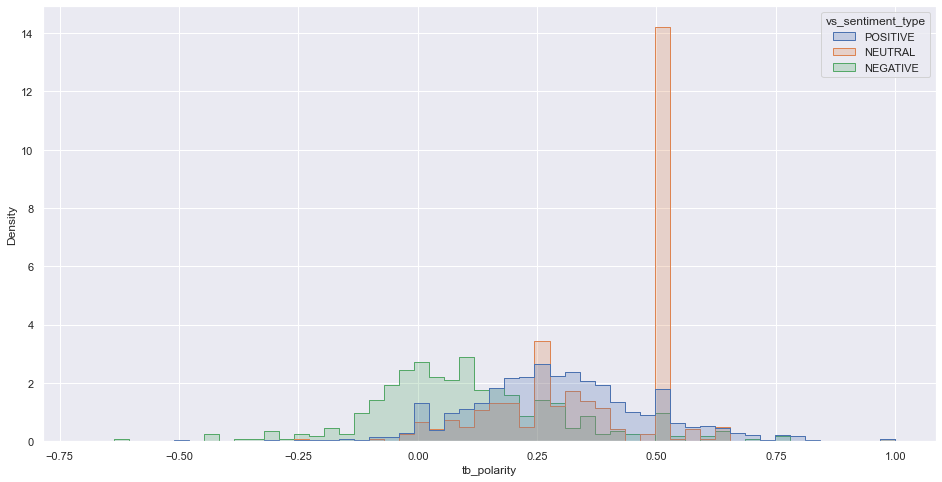

In [42]:
sns.set(rc={'figure.figsize':(16,8)})
sns.histplot(
    matches, x="tb_polarity", hue="vs_sentiment_type", element="step",
    stat="density", common_norm=False,
)

<AxesSubplot:xlabel='tb_subjectivity', ylabel='Density'>

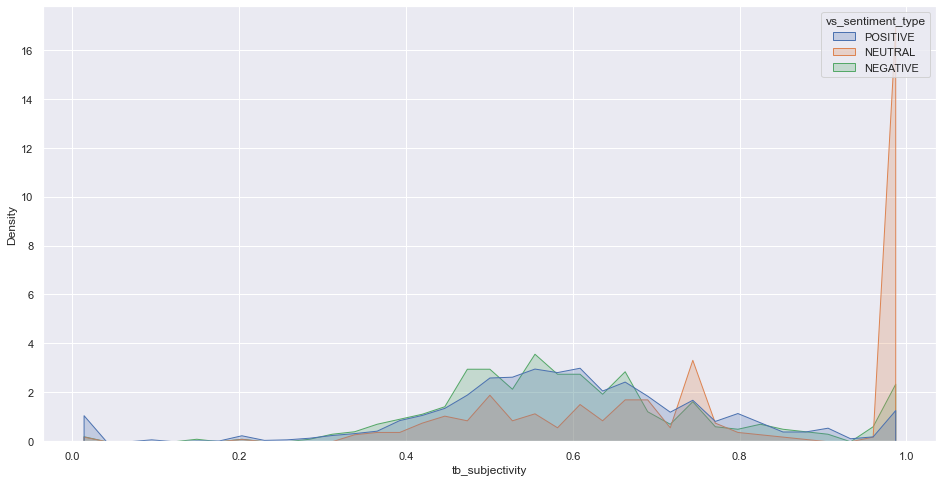

In [43]:
sns.set(rc={'figure.figsize':(16,8)})
sns.histplot(
    matches, x="tb_subjectivity", hue="vs_sentiment_type", element="poly",
    stat="density", common_norm=False,
)

Nos fijamos en las nubes de puntos y elegimos un conjunto de palabras negativas que aparezcan con frecuencia en las reseñas

In [44]:
specific_words = ['fast pass', 'queue', 'expensive']

query = '|'.join(specific_words)

df['query_match'] = df['Review_Text'].str.lower().str.contains(query)

df.head(5)

index  Review_ID  Rating     Reviewer_Location  \
0      0  670772142       4             Australia   
1      1  670682799       4           Philippines   
2      2  670623270       4  United Arab Emirates   
3      3  670607911       4             Australia   
4      4  670607296       4        United Kingdom   

                                         Review_Text               Branch  \
0  If you've ever been to Disneyland anywhere you...  Disneyland_HongKong   
1  Its been a while since d last time we visit HK...  Disneyland_HongKong   
2  Thanks God it wasn   t too hot or too humid wh...  Disneyland_HongKong   
3  HK Disneyland is a great compact park. Unfortu...  Disneyland_HongKong   
4                    the location is not in the city  Disneyland_HongKong   

   year  month                           text_withNo_Contractions  \
0  2019      4  If you have ever been to Disneyland anywhere y...   
1  2019      5  Its been a while since d last time we visit HK...   
2  2019      4  Thanks God it wasn   t too hot or too humid wh...   
3  2019      4  HK Disneyland is a great compact park. Unfortu...   
4  2019      4                    the location is not in the city   

                                          lower_case  \
0  if you have ever been to disneyland anywhere y...   
1  its been a while since d last time we visit hk...   
2  thanks god it wasn   t too hot or too humid wh...   
3  hk disneyland is a great compact park. unfortu...   
4                    the location is not in the city   

                                 text_with_no_digits  \
0  if you have ever been to disneyland anywhere y...   
1  its been a while since d last time we visit hk...   
2  thanks god it wasn   t too hot or too humid wh...   
3  hk disneyland is a great compact park. unfortu...   
4                    the location is not in the city   

                                   Text_withNo_punct  \
0  if you have ever been to disneyland anywhere y...   
1  its been a while since d last time we visit hk...   
2  thanks god it wasn t too hot or too humid when...   
3  hk disneyland is a great compact park unfortun...   
4                    the location is not in the city   

                                          lemmatized Sentiment  tb_polarity  \
0  disneyland find disneyland hong kong similar l...  Positive     0.243981   
1                         d time visit hk disneyland  Positive     0.000000   
2  thanks god wasn t hot humid visit park big iss...  Positive    -0.042857   
3  hk disneyland great compact park unfortunately...  Positive     0.140000   
4                                      location city  Positive     0.000000   

   tb_subjectivity                                           vs_score  \
0         0.561481  {'neg': 0.0, 'neu': 0.891, 'pos': 0.109, 'comp...   
1         0.066667  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   
2         0.350000  {'neg': 0.048, 'neu': 0.853, 'pos': 0.099, 'co...   
3         0.570000  {'neg': 0.058, 'neu': 0.803, 'pos': 0.138, 'co...   
4         0.000000  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   

   compound vs_sentiment_type  query_match  
0    0.7069          POSITIVE         True  
1    0.0000           NEUTRAL        False  
2    0.3818          POSITIVE        False  
3    0.5070          POSITIVE        False  
4    0.0000           NEUTRAL        False

In [45]:
matches2 = df[(df['query_match'] == True)]
matches2 

index  Review_ID  Rating Reviewer_Location  \
0          0  670772142       4         Australia   
17        17  670129921       3    United Kingdom   
28        28  669353396       5    United Kingdom   
29        29  669186152       3         Australia   
38        38  668209978       5         Australia   
...      ...        ...     ...               ...   
40021  42096   97219828       1    United Kingdom   
40032  42107   94480541       4    United Kingdom   
40034  42109   93597662       4    United Kingdom   
40040  42115   91995748       1    United Kingdom   
40042  42117   91827418       5    United Kingdom   

                                             Review_Text               Branch  \
0      If you've ever been to Disneyland anywhere you...  Disneyland_HongKong   
17     Around   60 per person and if you want to eat ...  Disneyland_HongKong   
28     We visited here on a Wednesday. We arrived for...  Disneyland_HongKong   
29     I need to say I have been to    home of Disney...  Disneyland_HongKong   
38     You have to visit to understand the memorable ...  Disneyland_HongKong   
...                                                  ...                  ...   
40021  just back from a 3 day 2 night Sun deal so it ...     Disneyland_Paris   
40032  I have just returned from here having spent 4 ...     Disneyland_Paris   
40034  we went in an off peak season and found that t...     Disneyland_Paris   
40040  We spent the 20 Dec 2010 in the Disney park an...     Disneyland_Paris   
40042  If staying at a Disney hotel make good use of ...     Disneyland_Paris   

       year  month                           text_withNo_Contractions  \
0      2019      4  If you have ever been to Disneyland anywhere y...   
17     2019      4  Around   60 per person and if you want to eat ...   
28     2019      4  We visited here on a Wednesday. We arrived for...   
29     2019      4  I need to say I have been to    home of Disney...   
38     2018      9  You have to visit to understand the memorable ...   
...     ...    ...                                                ...   
40021  2011      2  just back from a 3 day 2 night Sun deal so it ...   
40032  2011      1  I have just returned from here having spent 4 ...   
40034  2010     11  we went in an off peak season and found that t...   
40040  2010     12  We spent the 20 Dec 2010 in the Disney park an...   
40042  2010      9  If staying at a Disney hotel make good use of ...   

                                              lower_case  \
0      if you have ever been to disneyland anywhere y...   
17     around   60 per person and if you want to eat ...   
28     we visited here on a wednesday. we arrived for...   
29     i need to say i have been to    home of disney...   
38     you have to visit to understand the memorable ...   
...                                                  ...   
40021  just back from a 3 day 2 night sun deal so it ...   
40032  i have just returned from here having spent 4 ...   
40034  we went in an off peak season and found that t...   
40040  we spent the 20 dec 2010 in the disney park an...   
40042  if staying at a disney hotel make good use of ...   

                                     text_with_no_digits  \
0      if you have ever been to disneyland anywhere y...   
17     around    per person and if you want to eat or...   
28     we visited here on a wednesday. we arrived for...   
29     i need to say i have been to    home of disney...   
38     you have to visit to understand the memorable ...   
...                                                  ...   
40021  just back from a  day  night sun deal so it wa...   
40032  i have just returned from here having spent  f...   
40034  we went in an off peak season and found that t...   
40040  we spent the  dec  in the disney park and by l...   
40042  if staying at a disney hotel make good use of ...   

                                       Text_withNo_punct  \
0      if you have

<AxesSubplot:xlabel='tb_polarity', ylabel='Density'>

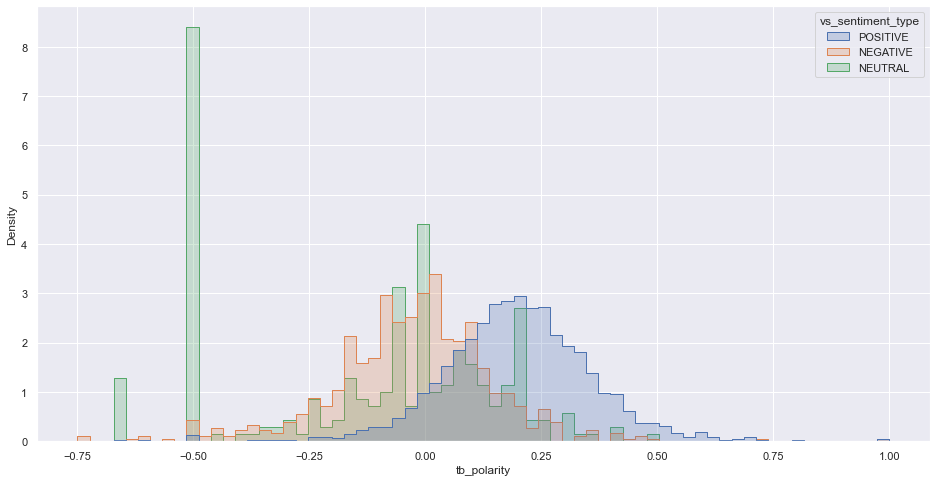

In [46]:
# the size of A4 paper
sns.set(rc={'figure.figsize':(16,8)})
sns.histplot(
    matches2, x="tb_polarity", hue="vs_sentiment_type", element="step",
    stat="density", common_norm=False,
)

<AxesSubplot:xlabel='tb_subjectivity', ylabel='Density'>

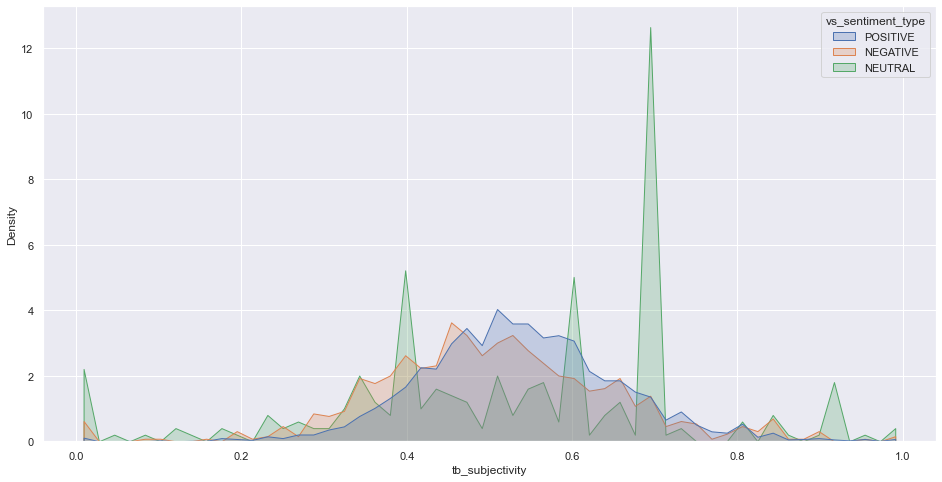

In [47]:
sns.set(rc={'figure.figsize':(16,8)})
sns.histplot(
    matches2, x="tb_subjectivity", hue="vs_sentiment_type", element="poly",
    stat="density", common_norm=False,
)

### Word2vec

In [48]:
text_corpus = []
for review in df['Text_withNo_punct']:
    words = review.split()
    text_corpus.append(words)
    
review2vec = w2v.Word2Vec(
    sg=1,
    seed=1,
    workers=multiprocessing.cpu_count(), # Number of threads to run in parallel.
    vector_size=500, # Dimensionality of the resulting word vectors.
    min_count=1, # Minimum word count threshold.
    window=5, # Context window length.
    sample=1e-3
)

review2vec.build_vocab(text_corpus)
print (len(text_corpus))

40022


In [49]:
review2vec.wv.most_similar("magic")

[('repeatedly', 0.18688754737377167),
 ('kidsenjoyed', 0.17069916427135468),
 ('visiting', 0.16429682075977325),
 ('northern', 0.16414226591587067),
 ('uniquehowever', 0.1591663807630539),
 ('qiute', 0.15450526773929596),
 ('opiniun', 0.15254972875118256),
 ('seamlessly', 0.15249691903591156),
 ('due', 0.15204140543937683),
 ('prohibitive', 0.14976811408996582)]

In [50]:
review2vec.wv.most_similar("queue")

[('revolution', 0.18434904515743256),
 ('cha', 0.1709136664867401),
 ('servicewell', 0.1652650535106659),
 ('benefited', 0.1604791134595871),
 ('sailing', 0.15489180386066437),
 ('originated', 0.15055114030838013),
 ('gail', 0.15054647624492645),
 ('muscular', 0.14958909153938293),
 ('togethernow', 0.1491631120443344),
 ('rolls', 0.1476990282535553)]

In [51]:
review2vec.wv.most_similar("family")

[('suffers', 0.20385509729385376),
 ('touchi', 0.19612443447113037),
 ('calendar', 0.18820428848266602),
 ('findingmore', 0.16510140895843506),
 ('ensues', 0.16200731694698334),
 ('latter', 0.16161158680915833),
 ('respecful', 0.1519249975681305),
 ('rediculus', 0.15146206319332123),
 ('revolution', 0.15140847861766815),
 ('disneylad', 0.1488610953092575)]

In [52]:
#Select 10000 words from our vocabulary
count = 10000
word_vectors_matrix = np.ndarray(shape=(count, 500), dtype='float64')
word_list = []
i = 0
for word in review2vec.wv.key_to_index:
    word_vectors_matrix[i] =  review2vec.wv[word]
    word_list.append(word)
    i = i+1
    if i == count:
        break
print("word_vectors_matrix shape is ", word_vectors_matrix.shape)

word_vectors_matrix shape is  (10000, 500)


In [53]:
#Compress the word vectors into 2D space
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
word_vectors_matrix_2d = tsne.fit_transform(word_vectors_matrix)
print("word_vectors_matrix_2d shape is ", word_vectors_matrix_2d.shape)

C:\Users\HP\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

C:\Users\HP\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



word_vectors_matrix_2d shape is  (10000, 2)


In [54]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1]) 
        for word, coords in [
            (word, word_vectors_matrix_2d[word_list.index(word)])
            for word in word_list
        ]
    ],
    columns=["word", "x", "y"]
)
print("Points DataFrame built")

Points DataFrame built


<AxesSubplot:xlabel='x', ylabel='y'>

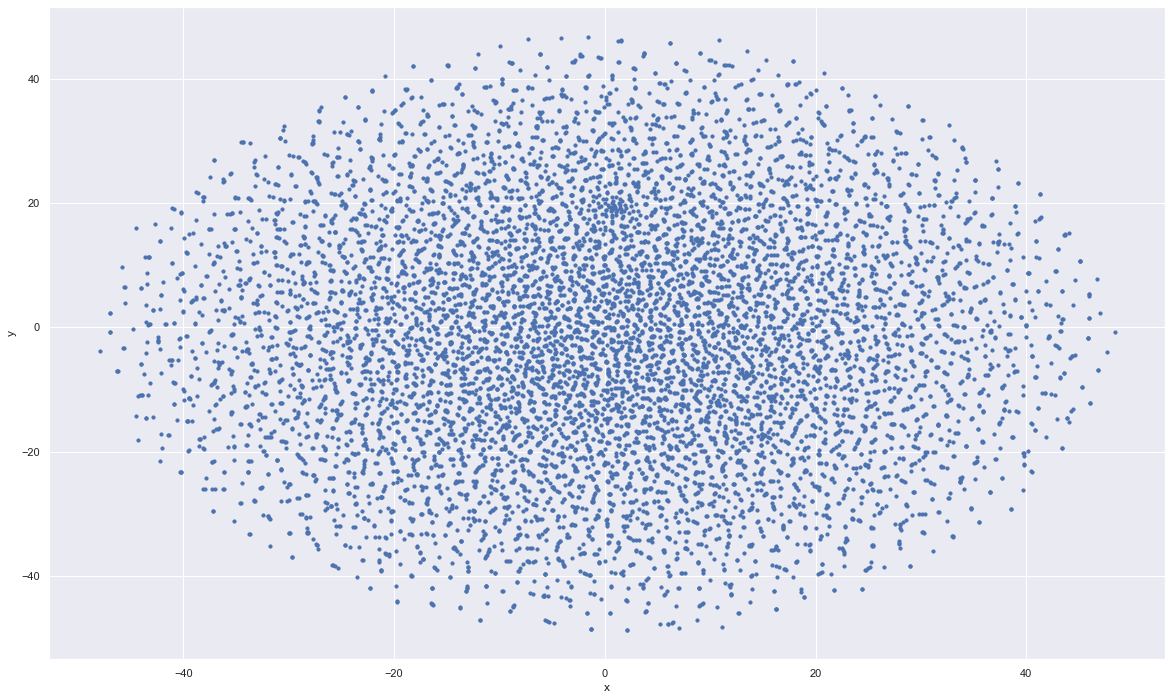

In [55]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [56]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) &
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1]) 
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(15, 7))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

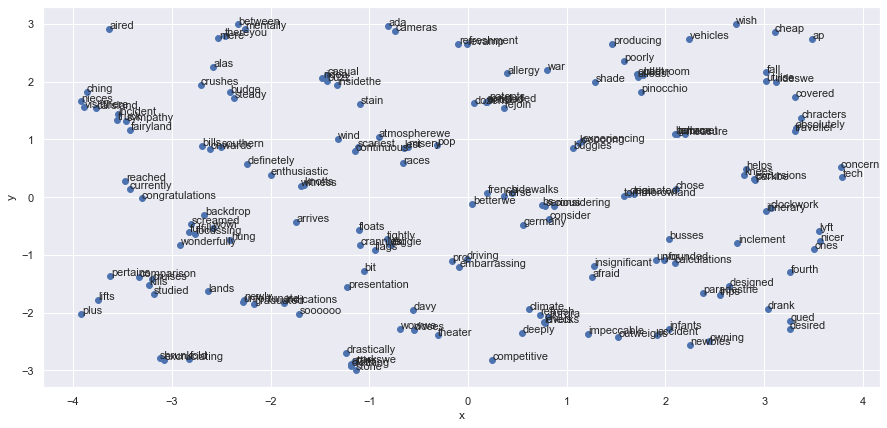

In [57]:
plot_region(x_bounds=(-4, 4), y_bounds=(-3, 3))

### TF-IDF

In [58]:
# Transform into TFIDF
corpus = df['Text_withNo_punct'].tolist()
tfidf = TfidfVectorizer(norm='l2', use_idf=True, max_df = 20,  smooth_idf=False, stop_words='english')
tfidf.fit_transform(corpus)

# 
for review, data in df.groupby('Branch'):
    feat = np.sum(tfidf.transform(data['Text_withNo_punct']).toarray(), axis=0)
    sort_idx = np.argsort(feat.flatten())[::-1] # Sort descending
    fav = [tfidf.get_feature_names()[idx] for idx in sort_idx.tolist()[:10]]
    print(review + "'s Fav words:")
    for w in fav:
        print('\t' + w)
    print()

C:\Users\HP\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



Disneyland_California's Fav words:
	vacations
	vegas
	electrical
	married
	president
	hoppers
	veterans
	bummer
	countless
	texas

Disneyland_HongKong's Fav words:
	staffs
	stickers
	connected
	hkdl
	muslim
	philharmagic
	philippines
	colorful
	wondrous
	esp

Disneyland_Paris's Fav words:
	cdg
	fiance
	smokers
	patch
	sceptical
	adored
	faults
	filthy
	mcdonalds
	heroes



In [59]:
for review, data in df.groupby('Reviewer_Location'):
    feat = np.sum(tfidf.transform(data['Text_withNo_punct']).toarray(), axis=0)
    sort_idx = np.argsort(feat.flatten())[::-1] # Sort descending
    fav = [tfidf.get_feature_names()[idx] for idx in sort_idx.tolist()[:10]]
    print(review + "'s Fav words:")
    for w in fav:
        print('\t' + w)
    print()

Afghanistan's Fav words:
	prep
	leading
	famopurs
	famouswe
	fanatastic
	fanatical
	fanatics
	fanbloodytasticwhat
	fanboy
	fancied

Albania's Fav words:
	programs
	parcs
	muffinsalso
	enjoyableeven
	amit
	drank
	fanboy
	famouswe
	fanatastic
	fanatical

Algeria's Fav words:
	hapiness
	necerssily
	cinema
	zurg
	fancied
	famouswe
	fanatastic
	fanatical
	fanatics
	fanbloodytasticwhat

Andorra's Fav words:
	disappointedthere
	fancier
	famouns
	famouswe
	fanatastic
	fanatical
	fanatics
	fanbloodytasticwhat
	fanboy
	fancied

Antigua and Barbuda's Fav words:
	links
	slick
	film
	fanhere
	fanbloodytasticwhat
	famly
	famopurs
	famouns
	famouswe
	fanatastic

Argentina's Fav words:
	las
	vegas
	refurbishing
	expencive
	capture
	choosing
	payments
	eurosyou
	nonsense
	animatronics

Armenia's Fav words:
	zurg
	fanciful
	famouswe
	fanatastic
	fanatical
	fanatics
	fanbloodytasticwhat
	fanboy
	fancied
	fancier

Aruba's Fav words:
	zurg
	fanciful
	famouswe
	fanatastic
	fanatical
	fanatics
	fanbloodytast

Ireland's Fav words:
	highest
	patricks
	throughly
	associated
	cent
	struggle
	product
	transported
	cdg
	disneylandwe

Isle of Man's Fav words:
	obsessed
	desk
	organisations
	diappointng
	phoned
	accepted
	refund
	seperate
	valid
	fixed

Israel's Fav words:
	creation
	allthe
	waking
	youre
	recommeded
	ustickets
	itdont
	teenagerswell
	explanations
	parksquite

Italy's Fav words:
	reachable
	cult
	insisting
	releasing
	italian
	multiculture
	comparisons
	affected
	theni
	everythig

Jamaica's Fav words:
	zurg
	fanciful
	famouswe
	fanatastic
	fanatical
	fanatics
	fanbloodytasticwhat
	fanboy
	fancied
	fancier

Japan's Fav words:
	treats
	perfection
	hyatt
	paragraph
	graduation
	ceases
	floridian
	hkdl
	expanded
	coolest

Jersey's Fav words:
	dod
	brill
	proved
	immensely
	oviously
	definatly
	impact
	refurbishments
	refurb
	burly

Jordan's Fav words:
	mesmerising
	ahhhhh
	visitcrowds
	shrink
	fascinating
	fancied
	famouswe
	fanatastic
	fanatical
	fanatics

Kazakhstan's Fav words:
	mee

Sri Lanka's Fav words:
	vehicle
	fulfilled
	adjacent
	drama
	traveler
	grissly
	renewing
	irrespective
	committed
	oneday

Sudan's Fav words:
	worthit
	zurg
	fanboy
	famopurs
	famouns
	famouswe
	fanatastic
	fanatical
	fanatics
	fanbloodytasticwhat

Suriname's Fav words:
	zurg
	fanciful
	famouswe
	fanatastic
	fanatical
	fanatics
	fanbloodytasticwhat
	fanboy
	fancied
	fancier

Sweden's Fav words:
	waiyning
	shown
	attractionseverything
	centers
	sleeps
	cdg
	plentiful
	tiresome
	playful
	waitingtime

Switzerland's Fav words:
	commercial
	arrangement
	afer
	ester
	hotelwe
	familywe
	million
	arranging
	cloudy
	drp

Taiwan's Fav words:
	highline
	expanded
	splendid
	playful
	seethe
	unhappyotherwise
	joyful
	kiddos
	aren
	legthe

Tanzania's Fav words:
	monney
	disneylandnew
	fo
	installed
	fare
	outnumbered
	holdups
	crowdedplenty
	ridessince
	users

Thailand's Fav words:
	philharmagic
	moutain
	blasters
	understanding
	spacious
	browsing
	nephews
	hkdl
	upwards
	equipment

The Bahamas's F

### Topic Modeling

In [61]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data = df.Review_Text.values.tolist()
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]
data_words = list(sent_to_words(data))

In [62]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['if', 'youve', 'ever', 'been', 'to', 'disneyland', 'anywhere', 'youll', 'find', 'disneyland_hong_kong', 'very', 'similar', 'in', 'the', 'layout', 'when', 'you', 'walk', 'into', 'main_street', 'it', 'has', 'very', 'familiar', 'feel', 'one', 'of', 'the', 'rides', 'its', 'small', 'world', 'is', 'absolutely', 'fabulous', 'and', 'worth', 'doing', 'the', 'day', 'we', 'visited', 'was', 'fairly', 'hot', 'and', 'relatively', 'busy', 'but', 'the', 'queues', 'moved', 'fairly', 'well']


In [63]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [66]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['ve', 'ever', 'disneyland', 'anywhere', 'find', 'similar', 'layout', 'walk', 'main_street', 'familiar', 'feel', 'ride', 'small', 'world', 'absolutely', 'fabulous', 'worth', 'day', 'visit', 'fairly', 'hot', 'relatively', 'busy', 'queue', 'move', 'fairly', 'well']]


In [67]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [68]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=7, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [69]:
# Print the Keyword in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.065*"go" + 0.058*"day" + 0.048*"ride" + 0.027*"good" + 0.026*"great" + 0.023*"child" + 0.022*"see" + 0.020*"kid" + 0.020*"place" + 0.016*"really"'), (1, '0.055*"get" + 0.042*"queue" + 0.030*"take" + 0.025*"stay" + 0.024*"food" + 0.022*"hotel" + 0.020*"wait" + 0.020*"hour" + 0.018*"ride" + 0.017*"ticket"'), (2, '0.050*"feel" + 0.035*"whole" + 0.028*"read" + 0.027*"space_mountain" + 0.026*"full" + 0.024*"cheap" + 0.021*"meal" + 0.020*"large" + 0.020*"run" + 0.020*"tell"'), (3, '0.083*"ve" + 0.044*"short" + 0.040*"m" + 0.039*"princess" + 0.036*"poor" + 0.035*"orlando" + 0.033*"expectation" + 0.024*"d" + 0.022*"write" + 0.020*"idea"'), (4, '0.045*"always" + 0.045*"train" + 0.038*"dream" + 0.030*"work" + 0.024*"station" + 0.024*"entrance" + 0.022*"s" + 0.019*"pirate" + 0.018*"helpful" + 0.018*"right"'), (5, '0.203*"park" + 0.034*"attraction" + 0.027*"close" + 0.026*"find" + 0.023*"big" + 0.021*"return" + 0.020*"price" + 0.017*"open" + 0.016*"look" + 0.016*"studio"'), (6, '0.115*"tim

In [70]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.329305 -0.024489       1        1  35.519877
1      0.248115 -0.076106       2        1  23.374301
6     -0.050427  0.417595       3        1  16.557257
5     -0.091587  0.034700       4        1  13.613732
2     -0.151420 -0.127999       5        1   4.399733
4     -0.144271 -0.120144       6        1   4.334417
3     -0.139716 -0.103557       7        1   2.200684, topic_info=         Term          Freq         Total Category  logprob  loglift
38       park  16070.000000  16070.000000  Default  30.0000  30.0000
27       time  11099.000000  11099.000000  Default  29.0000  29.0000
96     disney   9156.000000   9156.000000  Default  28.0000  28.0000
21      visit   8771.000000   8771.000000  Default  27.0000  27.0000
49         go  13361.000000  13361.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
1476     star    132.890224    133.703102   Topic7  -4.5684   3.8103
552       mid    124.659167    125.472673   Topic7  -4.6323   3.8099
642   comment    122.698308    123.512998   Topic7  -4.6482   3.8098
644      post    121.018993    121.841120   Topic7  -4.6620   3.8096
550      true    118.649709    119.463450   Topic7  -4.6817   3.8096

[245 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         3  0.998241  absolutely
622       3  0.999561         ago
162       2  0.999764        also
304       6  0.999119      always
163       1  0.999611     amazing
...     ...       ...         ...
752       7  0.997865      winter
57        6  0.999407        work
24        3  0.999089       world
929       7  0.997980       write
211       3  0.999783        year

[219 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 7, 6, 3, 5, 4])